<a href="https://colab.research.google.com/github/woo2201/sampleCases/blob/reservior/AmericanExpress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
cd /content/drive/MyDrive/dataset/AmericanExpress/

/content/drive/MyDrive/dataset/AmericanExpress


In [26]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm

In [28]:
path = "/content/drive/MyDrive/dataset/AmericanExpress/"
filenames = glob.glob(path + "*.csv")

In [30]:
train_df = pd.read_csv(filenames[1], chunksize = 130000)
train_label = pd.read_csv(filenames[0])

In [31]:
train_example = train_df.__next__()

In [10]:
train_example.sample(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
10656,007f209a6937ed97573eb10a15e1ca1989d1ff4fe12fd4...,2018-01-03,0.869034,0.271611,0.026065,1.003477,0.006662,0.138556,0.003964,0.007664,...,NaN,NaN,NaN,0.002067,0.002325,0.005928,NaN,0.000403,0.008137,0.003738
11443,0088b275a78e3151f28b69f6ad85019dba678c280d9a8a...,2017-08-18,0.671976,0.001854,0.246693,0.033189,0.001982,0.093679,0.008308,0.663930,...,NaN,NaN,NaN,0.003045,0.005833,0.008800,NaN,0.005977,0.003478,0.009553
4931,003f56dff9ddbe1ea99f99041e116f302b52abcfe4640f...,2017-08-30,0.577918,0.032445,0.116389,0.134091,0.508930,0.170127,0.008593,0.182335,...,NaN,NaN,NaN,0.006298,0.000965,0.003984,NaN,0.006986,0.008559,0.009815
3141,0025fbc119154ef74871fd820ae5eadf602e42995c7b7b...,2017-05-07,0.811687,0.009742,0.015245,1.007999,0.008985,0.133781,0.001678,0.009017,...,NaN,NaN,NaN,0.001489,0.001432,0.000323,NaN,0.004409,0.009442,0.004843
3473,002ae7c18dbbb0262b424c78589c22902b7bb98591f0cc...,2018-03-22,0.689830,0.596235,0.046913,1.006277,0.006535,0.123177,0.000582,0.000639,...,NaN,NaN,NaN,0.000526,0.002318,0.003960,NaN,0.002575,0.005322,0.007176


Features are anonymized and normalized, and fall into the following general categories:

- D_* = Delinquency variables
- S_* = Spend variables
- P_* = Payment variables
- B_* = Balance variables
- R_* = Risk variables

In [11]:
delinquency_Cols = ['customer_ID', 'S_2'] + [col for col in train_example.columns if col.startswith('D_')]
spend_Cols = ['customer_ID', 'S_2'] + [col for col in train_example.columns if col.startswith('S_')]
payment_Cols = ['customer_ID', 'S_2'] + [col for col in train_example.columns if col.startswith('P_')]
balance_Cols = ['customer_ID', 'S_2'] + [col for col in train_example.columns if col.startswith('B_')]
risk_Cols = ['customer_ID', 'S_2'] + [col for col in train_example.columns if col.startswith('R_')]

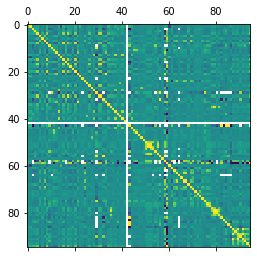

In [12]:
import matplotlib.pyplot as plt

corr_delin = (
                train_example
                    [delinquency_Cols].merge(train_label,
                                            left_on = 'customer_ID',
                                            right_on = 'customer_ID',
                                            how = 'left')
                    .drop(['customer_ID'], axis = 1)
                    .corr()
            )


plt.matshow(corr_delin)
plt.show()

In [17]:
train_example[delinquency_Cols][train_example.customer_ID == '0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a'].

,customer_ID,S_2,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_47,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.001733,0.008771,NaN,NaN,0.000630,0.708906,0.358587,0.525351,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.005775,0.000798,NaN,NaN,0.002526,0.712795,0.353630,0.521311,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.091505,0.007598,NaN,NaN,0.007605,0.720884,0.334650,0.524568,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.002455,0.000685,NaN,NaN,0.006406,0.723997,0.323271,0.530929,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.002483,0.004653,NaN,NaN,0.007731,0.720619,0.231009,0.529305,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.001746,0.009857,NaN,NaN,0.004128,0.721371,0.275963,0.529762,...,NaN,NaN,NaN,0.001924,0.008598,0.004529,NaN,0.000674,0.002223,0.002884
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.002183,0.006603,NaN,NaN,0.009397,0.721725,0.307869,0.535747,...,NaN,NaN,NaN,0.001336,0.004361,0.009387,NaN,0.007727,0.007661,0.002225
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.003029,0.009527,NaN,NaN,0.001399,0.723293,0.519619,0.533295,...,NaN,NaN,NaN,0.002397,0.008452,0.005553,NaN,0.001831,0.009616,0.007385
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.009896,0.002519,NaN,NaN,0.002578,0.730918,0.430077,0.539065,...,NaN,NaN,NaN,0.009742,0.003968,0.007945,NaN,0.008722,0.004369,0.000995
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.001082,0.004626,NaN,NaN,0.007595,0.735001,0.430871,0.542119,...,NaN,NaN,NaN,0.003611,0.009607,0.007266,NaN,0.008763,0.004753,0.009068


In [9]:
train_example.isna().mean()

customer_ID    0.000000
S_2            0.000000
P_2            0.007000
D_39           0.000000
B_1            0.000000
                 ...   
D_141          0.016077
D_142          0.841462
D_143          0.016077
D_144          0.006538
D_145          0.016077
Length: 190, dtype: float64